In [35]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, ConvLSTM2D, Dropout, Flatten, RepeatVector, Reshape, \
    TimeDistributed, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import LSTM
from numpy import array
from numpy import hstack

In [37]:
initial = pd.read_csv("data/bus_running_times_feature_added_all.csv")

In [38]:
busses_new = initial[['trip_id','deviceid','direction','segment','date','start_time','end_time','run_time','run_time_in_seconds']]

In [39]:
busses_new.dropna(inplace=True)

In [40]:
segments = 15
time_step = 60 # in minutes
previous_steps = 16
pred_steps = 2
min = 0
start_time = '06:00:00'
end_time = '19:00:00'

In [41]:
def getAvgRuntimeWithSegment(dataframe, time_step,start_time,end_time,min):
    dataframe = dataframe.copy()
    
    # Convert the 'date' and 'start_time' columns to datetime objects
    dataframe['end_time'] = pd.to_datetime(dataframe['end_time'])
    # Set the start and end times for the time window
    start_time = pd.to_datetime(start_time).time()
    end_time = pd.to_datetime(end_time).time()

    # Create a list to store the data for the new dataframe
    data = []

    # Iterate over the unique dates in the 'date' column
    for date in dataframe['date'].unique():
        # Filter the rows for the current date
        df_date = dataframe[dataframe['date'] == date]
        df_date.loc[:, 'end_time'] = df_date['end_time'].dt.time  # Use .loc to modify the original DataFrame
        date = date + pd.Timedelta(minutes=min)
        # Create a time range for the current date with the specified time step
        time_range = pd.date_range(date, date + pd.Timedelta(days=1), freq=f'{time_step}T')

        # Iterate over the time range
        for start, end in zip(time_range[:-1], time_range[1:]):
            # Check if the start time is within the specified time window
            if start.time() >= start_time and start.time() < end_time:
                # Filter the rows for the current time window
                mask = (df_date['end_time'] >= start.time()) & (df_date['end_time'] < end.time())
                df_time_window = df_date[mask]
                # Calculate the average run time for each segment in the current time window
                avg_run_time = df_time_window.groupby('segment')['run_time_in_seconds'].mean().reset_index()

                # Append the data to the data list
                for row in avg_run_time.itertuples():
                    data.append((date, start.time(), row.segment, row.run_time_in_seconds))

    # Create a new dataframe from the data list
    df_avg_run_time = pd.DataFrame(data, columns=['date', 'start_time', 'segment', 'avg_run_time'])
    return df_avg_run_time

def handleOutliers(df):
    # Calculate the median of avg_run_time
    median_avg_run_time = df['avg_run_time'].median()

    # Calculate the absolute deviations
    df['abs_deviation'] = np.abs(df['avg_run_time'] - median_avg_run_time)

    # Calculate the median absolute deviation (MAD)
    mad = df['abs_deviation'].median()

    # Set a threshold (for example, 3 times MAD) to identify outliers
    threshold = 1.5 * mad

    # Replace outliers with the median value
    df.loc[df['abs_deviation'] > threshold, 'avg_run_time'] = median_avg_run_time

    # Drop the temporary column
    df = df.drop(columns=['abs_deviation'])

    return df

def fillTimeSteps(df_avg_run_time, startTime, endTime, time_step, num_segments):
    start_Time = pd.to_datetime(startTime).time()

    end_Time = pd.to_datetime(endTime).time()
    # Create a new DataFrame to store the missing data
    data = []

    # Iterate over the unique dates in the 'date' column
    for date in df_avg_run_time['date'].unique():
        # Filter the rows for the current date
        df_date = df_avg_run_time[df_avg_run_time['date'] == date]

        # Create a time range for the current date with the specified time step
        time_range = pd.date_range(date, date + pd.Timedelta(days=1), freq=f'{time_step}T').time

        # Iterate over the time range
        for t in time_range:
            # Check if the start time is within the specified time window
            if start_Time <= t < end_Time:
                # Check if the current start time is present in the dataframe
                if not (df_date['start_time'] == t).any():
                    # Add rows for the missing start time and segments
                    for segment in range(1, num_segments + 1):
                        data.append((date, t, segment, 0))

    # Create a new DataFrame from the data list
    df_missing = pd.DataFrame(data, columns=['date', 'start_time', 'segment', 'avg_run_time'])

    # Concatenate the new DataFrame with the original DataFrame
    df_avg_run_time = pd.concat([df_avg_run_time, df_missing], ignore_index=True)
    # Sort the rows of the dataframe by the 'date', 'start_time', and 'segment' columns
    df_avg_run_time = df_avg_run_time.sort_values(by=['date', 'start_time', 'segment'])
    return df_avg_run_time

In [42]:
mask = busses_new['segment'] <= segments

In [43]:
busses_new = busses_new[mask]

In [44]:
# Convert the 'date' column to a datetime object
busses_new['date'] = pd.to_datetime(busses_new['date'])

# Create a boolean mask to filter rows with dates on or after 10/1/2022
mask = busses_new['date'] >= '2022-10-01'

# Create the train and test dataframes
busses_train = busses_new[~mask]
busses_test = busses_new[mask]

In [45]:
df_avg_run_time = getAvgRuntimeWithSegment(busses_train,time_step,start_time,end_time,min)

In [46]:
df_avg_run_time

,date,start_time,segment,avg_run_time
0,2021-10-01,06:00:00,1.0,69.0
1,2021-10-01,06:00:00,2.0,210.0
2,2021-10-01,06:00:00,3.0,496.0
3,2021-10-01,06:00:00,4.0,195.0
4,2021-10-01,06:00:00,5.0,97.0
...,...,...,...,...
35962,2022-09-30,18:00:00,11.0,154.0
35963,2022-09-30,18:00:00,12.0,166.0
35964,2022-09-30,18:00:00,13.0,158.0
35965,2022-09-30,18:00:00,14.0,115.0


In [47]:
df = df_avg_run_time

In [48]:
# Create a MultiIndex with all combinations of date, start_time, and segment
idx = pd.MultiIndex.from_product([df['date'].unique(), df['start_time'].unique(), range(1, segments + 1)],
                                  names=['date', 'start_time', 'segment'])

# Reindex the dataframe using the new MultiIndex
df = df.set_index(['date', 'start_time', 'segment']).reindex(idx, fill_value=0).reset_index()

df = fillTimeSteps(df, start_time, end_time, time_step, segments)

In [49]:
df

,date,start_time,segment,avg_run_time
0,2021-10-01,06:00:00,1,69.0
1,2021-10-01,06:00:00,2,210.0
2,2021-10-01,06:00:00,3,496.0
3,2021-10-01,06:00:00,4,195.0
4,2021-10-01,06:00:00,5,97.0
...,...,...,...,...
46780,2022-09-30,18:00:00,11,154.0
46781,2022-09-30,18:00:00,12,166.0
46782,2022-09-30,18:00:00,13,158.0
46783,2022-09-30,18:00:00,14,115.0


In [50]:
# Pivot the DataFrame
pivoted_df = df.pivot_table(index=['date', 'start_time'], columns='segment', values='avg_run_time', aggfunc='first')

pivoted_df

segment                        1           2           3           4   \
date       start_time                                                   
2021-10-01 06:00:00     69.000000  210.000000  496.000000  195.000000   
           07:00:00      0.000000    0.000000    0.000000    0.000000   
           08:00:00     74.000000  225.000000  436.000000  180.000000   
           09:00:00    123.000000  221.000000  366.000000  133.000000   
           10:00:00     88.000000  196.000000  467.000000  168.000000   
...                           ...         ...         ...         ...   
2022-09-30 14:00:00    116.333333  258.333333  399.000000  246.000000   
           15:00:00    119.500000  289.000000  426.666667  235.333333   
           16:00:00    122.500000  268.500000  483.500000  240.000000   
           17:00:00     93.500000  161.500000  568.000000  239.000000   
           18:00:00      0.000000    0.000000    0.000000    0.000000   

segment                        5           6          7           8   \
date       start_time                                                  
2021-10-01 06:00:00     97.000000    0.000000   0.000000    0.000000   
           07:00:00      0.000000  210.000000  45.000000   99.000000   
           08:00:00      0.000000    0.000000   0.000000    0.000000   
           09:00:00    115.500000  172.500000  45.000000   84.000000   
           10:00:00    152.000000  182.000000  60.000000   75.000000   
...                           ...         ...        ...         ...   
2022-09-30 14:00:00    133.333333  320.000000  52.000000   72.000000   
           15:00:00    143.000000  363.000000  64.000000  111.500000   
           16:00:00    161.500000  359.500000  50.000000   88.333333   
           17:00:00    126.000000  245.666667  64.333333   99.333333   
           18:00:00      0.000000    0.000000   0.000000    0.000000   

segment                       9      10     11          12     13          14  \
date       start_time                                                           
2021-10-01 06:00:00     0.000000    0.0    0.0    0.000000    0.0    0.000000   
           07:00:00    34.000000  149.0  150.0  161.000000  139.0  102.000000   
           08:00:00     0.000000    0.0    0.0    0.000000    0.0    0.000000   
           09:00:00    16.000000  168.0  221.0  255.000000  153.0  118.000000   
           10:00:00    36.000000  180.0    0.0    0.000000    0.0    0.000000   
...                          ...    ...    ...         ...    ...         ...   
2022-09-30 14:00:00    36.500000  178.0  148.5  144.500000  157.0  109.000000   
           15:00:00    43.000000  216.0  258.0  184.500000  163.0  142.000000   
           16:00:00    37.333333  188.0  277.0  189.333333  158.0  178.666667   
           17:00:00    35.666667  154.0  122.5  160.000000  139.0  262.500000   
           18:00:00     0.000000    0.0  154.0  166.000000  158.0  115.000000   

segment                        15  
date       start_time              
2021-10-01 06:00:00      0.000000  
           07:00:00    234.000000  
           08:00:00      0.000000  
           09:00:00    305.000000  
           10:00:00      0.000000  
...                           ...  
2022-09-30 14:00:00    343.000000  
           15:00:00    353.333333  
           16:00:00    326.500000  
           17:00:00    315.666667  
           18:00:00    382.000000  

[3120 rows x 15 columns]

In [51]:
from sklearn.preprocessing import MinMaxScaler

# Get the list of integer column names (segments)
segment_columns = pivoted_df.columns

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Loop through each segment column and normalize it
for segment in segment_columns:
    pivoted_df[segment] = scaler.fit_transform(pivoted_df[segment].values.reshape(-1, 1))

pivoted_df

segment                      1         2         3         4         5   \
date       start_time                                                     
2021-10-01 06:00:00    0.076667  0.230769  0.456806  0.212882  0.128307   
           07:00:00    0.000000  0.000000  0.000000  0.000000  0.000000   
           08:00:00    0.082222  0.247253  0.401547  0.196507  0.000000   
           09:00:00    0.136667  0.242857  0.337079  0.145197  0.152778   
           10:00:00    0.097778  0.215385  0.430098  0.183406  0.201058   
...                         ...       ...       ...       ...       ...   
2022-09-30 14:00:00    0.129259  0.283883  0.367471  0.268559  0.176367   
           15:00:00    0.132778  0.317582  0.392951  0.256914  0.189153   
           16:00:00    0.136111  0.295055  0.445294  0.262009  0.213624   
           17:00:00    0.103889  0.177473  0.523117  0.260917  0.166667   
           18:00:00    0.000000  0.000000  0.000000  0.000000  0.000000   

segment                      6         7         8         9         10  \
date       start_time                                                     
2021-10-01 06:00:00    0.000000  0.000000  0.000000  0.000000  0.000000   
           07:00:00    0.288066  0.085066  0.492537  0.259542  0.276096   
           08:00:00    0.000000  0.000000  0.000000  0.000000  0.000000   
           09:00:00    0.236626  0.085066  0.417910  0.122137  0.311303   
           10:00:00    0.249657  0.113422  0.373134  0.274809  0.333539   
...                         ...       ...       ...       ...       ...   
2022-09-30 14:00:00    0.438957  0.098299  0.358209  0.278626  0.329833   
           15:00:00    0.497942  0.120983  0.554726  0.328244  0.400247   
           16:00:00    0.493141  0.094518  0.439469  0.284987  0.348363   
           17:00:00    0.336991  0.121613  0.494196  0.272265  0.285361   
           18:00:00    0.000000  0.000000  0.000000  0.000000  0.000000   

segment                      11        12        13        14        15  
date       start_time                                                    
2021-10-01 06:00:00    0.000000  0.000000  0.000000  0.000000  0.000000  
           07:00:00    0.229358  0.243570  0.325146  0.198444  0.260000  
           08:00:00    0.000000  0.000000  0.000000  0.000000  0.000000  
           09:00:00    0.337920  0.385779  0.357895  0.229572  0.338889  
           10:00:00    0.000000  0.000000  0.000000  0.000000  0.000000  
...                         ...       ...       ...       ...       ...  
2022-09-30 14:00:00    0.227064  0.218608  0.367251  0.212062  0.381111  
           15:00:00    0.394495  0.279123  0.381287  0.276265  0.392593  
           16:00:00    0.423547  0.286435  0.369591  0.347601  0.362778  
           17:00:00    0.187309  0.242057  0.325146  0.510700  0.350741  
           18:00:00    0.235474  0.251135  0.369591  0.223735  0.424444  

[3120 rows x 15 columns]

In [52]:
columns = len(pivoted_df.columns)
sequences = [array(pivoted_df[[i+1]]) for i in range(columns)]

In [53]:
sequence_length_x = previous_steps

future_steps = pred_steps

arrangement_x = array([ [ [sequences[k][i+j] for k in range(columns)]
                          for j in range(sequence_length_x) ] for i in range(len(sequences[0]) - sequence_length_x + 1) ])


X0 = arrangement_x.reshape((len(arrangement_x),sequence_length_x,columns,1,1))
X = X0[:-future_steps]

In [54]:
sequence_length_y = columns

arrangement_y = array([
    [[sequences[j][i + sequence_length_y - 1 + k] for j in range(columns)] for k in range(future_steps)]
    for i in range(len(sequences[0]) - sequence_length_y + 1 - (future_steps - 1))
])


y = arrangement_y.reshape((len(arrangement_y),future_steps,columns,1,1))
# y = arrangement_y
y = y[sequence_length_x-(columns - 1):]
# print(sequence_length_x-(columns - 1))
arrangement_y

array([[[[0.        ],
         [0.        ],
         [0.52495856],
         ...,
         [0.3625731 ],
         [0.20914397],
         [0.275     ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.11444444],
         [0.1978022 ],
         [0.46601584],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       ...,


       [[[0.13277778],
         [0.31758242],
         [

In [55]:
print(len(X),len(y))

3103 3103


In [56]:
X[11]

array([[[[0.        ]],

        [[1.        ]],

        [[0.36562903]],

        [[0.31877729]],

        [[0.20502646]],

        [[0.39643347]],

        [[0.08506616]],

        [[0.43781095]],

        [[0.18320611]],

        [[0.31871526]],

        [[0.27675841]],

        [[0.25718608]],

        [[0.45847953]],

        [[0.15564202]],

        [[0.34666667]]],


       [[[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]]],


       [[[0.11666667]],

        [[0.24065934]],

        [[0.33431571]],

        [[0.19432314]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]

In [57]:
y[10]

array([[[[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]],

        [[0.        ]]],


       [[[0.07      ]],

        [[0.23956044]],

        [[0.30668631]],

        [[0.18995633]],

        [[0.1494709 ]],

        [[0.3909465 ]],

        [[0.07750473]],

        [[0.41293532]],

        [[0.15267176]],

        [[0.21124151]],

        [[0.15902141]],

        [[0.37216339]],

        [[0.41403509]],

        [[0.25097276]],

        [[0.        ]]]])

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=42)

In [59]:
len(X_train)

31

In [60]:
model = Sequential()
# model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
# model.add(LSTM(100, activation='relu'))
# model.add(BatchNormalization(name='batch_norm_0', input_shape=(sequence_length_x, columns,1, 1)))
# model.add(ConvLSTM2D(name='conv_lstm_1', filters=64, kernel_size=(5, 1), padding='same', return_sequences=True, activation='relu'))
model.add(ConvLSTM2D(name='conv_lstm_1', filters=64, kernel_size=(9, 1), padding='same', return_sequences=True, activation='relu',input_shape=(sequence_length_x, columns,1, 1)))
# model.add(Dropout(0.2, name='dropout_1'))
# model.add(BatchNormalization(name='batch_norm_1'))
model.add(ConvLSTM2D(name='conv_lstm_2', filters=64, kernel_size=(6, 1), padding='same', return_sequences=False, activation='relu'))
# model.add(Dropout(0.2, name='dropout_2'))
# model.add(BatchNormalization(name='batch_norm_2'))
model.add(Flatten())
model.add(RepeatVector(future_steps))
model.add(Reshape((future_steps, columns, 1, 64)))
model.add(ConvLSTM2D(name='conv_lstm_3', filters=64, kernel_size=(9, 1), padding='same', return_sequences=True, activation='relu'))
# model.add(Dropout(0.2, name='dropout_3'))
# model.add(BatchNormalization(name='batch_norm_3'))
model.add(ConvLSTM2D(name='conv_lstm_4', filters=64, kernel_size=(6, 1), padding='same', return_sequences=True, activation='relu'))
model.add(TimeDistributed(Dense(units=1, name='dense_1', activation='relu')))
# optimizer = RMSprop() #lr=0.0001, rho=0.9, epsilon=1e-08, decay=0.9)
model.compile(loss = "mse", optimizer = 'adam')
# fit model
model.fit(X_train, y_train, epochs=1,batch_size=64,validation_split=0.1, verbose=1)

1/1 [==============================] - 14s 14s/step - loss: 0.0759 - val_loss: 0.0805


In [61]:
predictions = model.predict(X_test)

96/96 [==============================] - 13s 125ms/step


In [62]:
arr_pred = [[] for i in range(columns)]
arr_test = [[] for i in range(columns)]


for i in range(len(predictions)):
  for j in range(columns):
    temp_pred = []
    temp_test = []
    for k in range(future_steps):
      temp_pred.append(predictions[i][k][j][0][0])
      temp_test.append(y_test[i][k][j][0][0])
    arr_pred[j].append(temp_pred)
    arr_test[j].append(temp_test)


time step 1


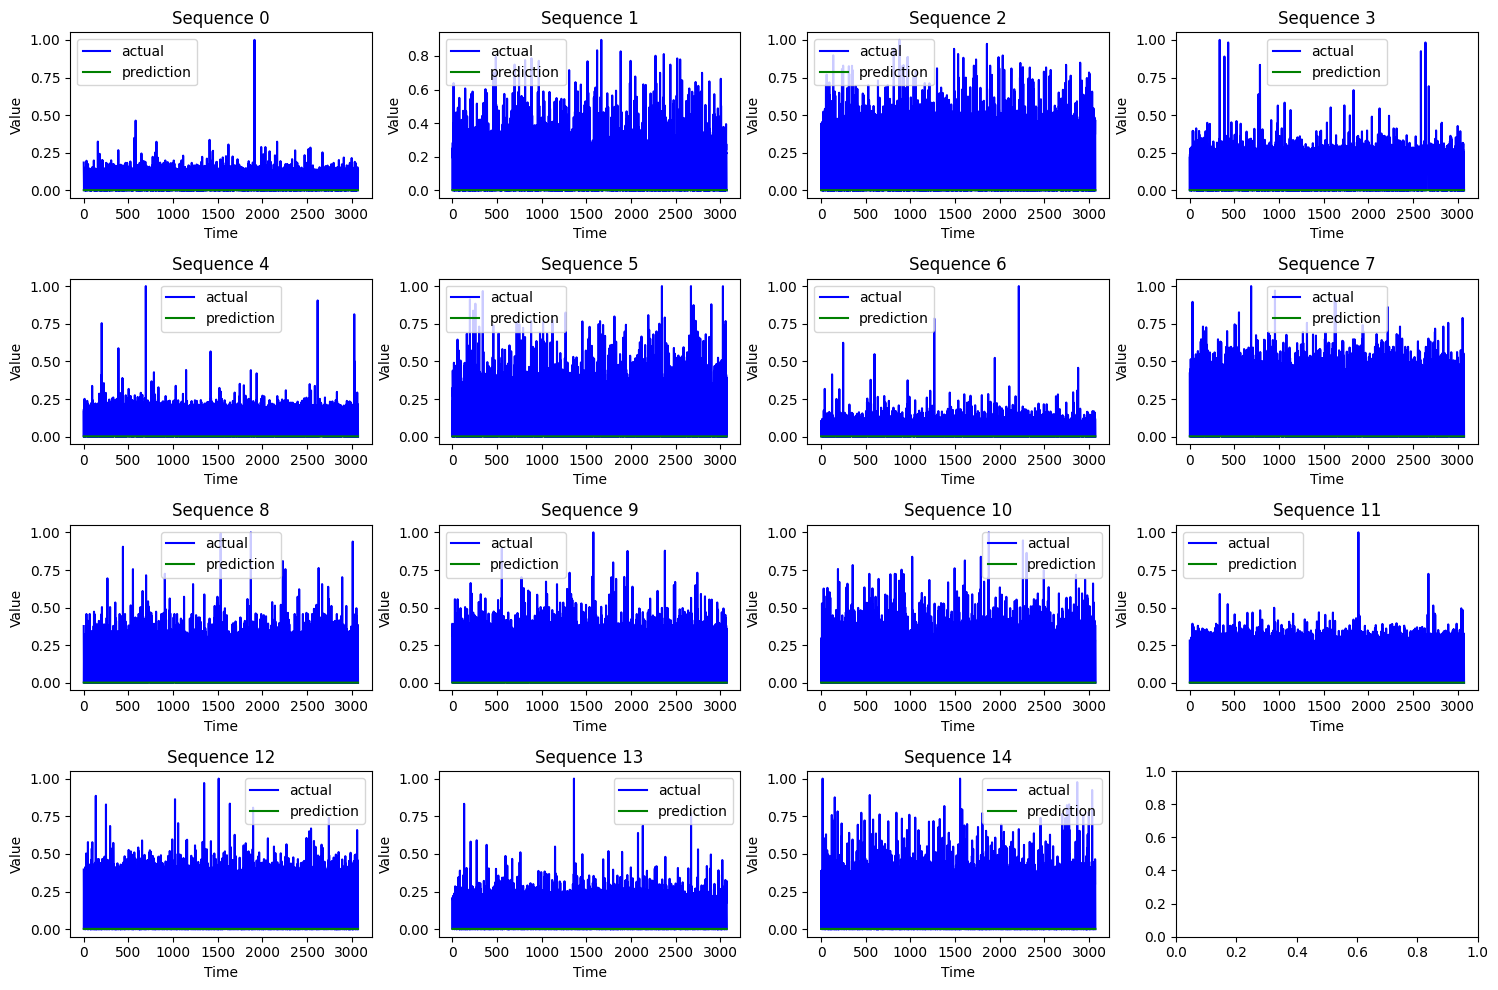

time step 2


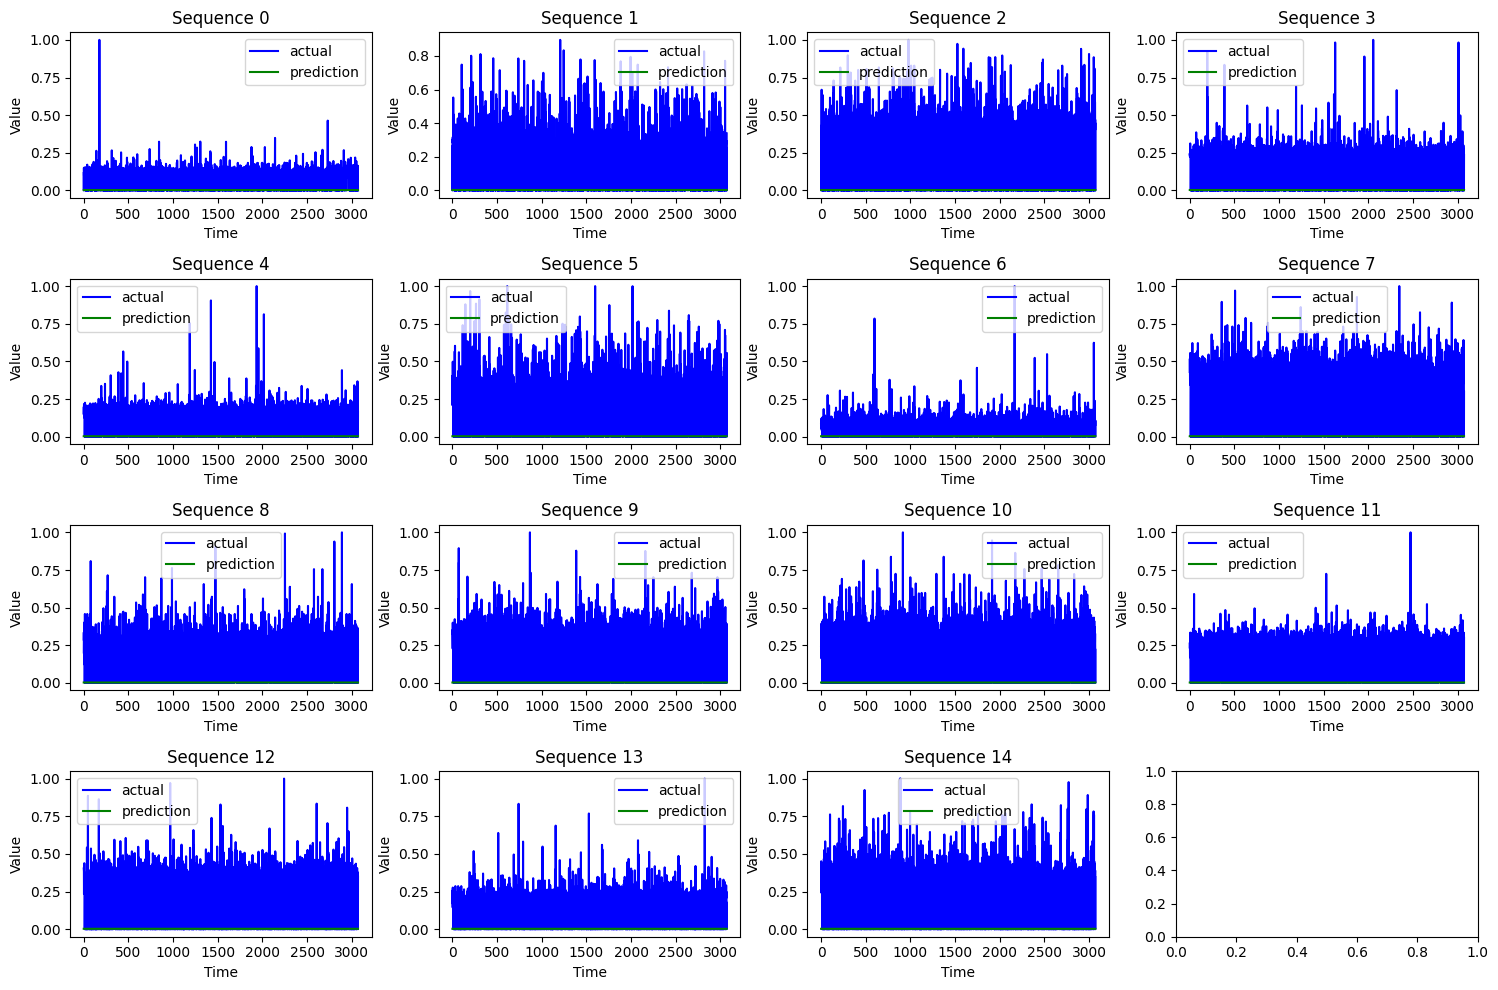

In [63]:
import matplotlib.pyplot as plt

for k in range(future_steps):
  print(f"time step {k+1}")
  num_plots = len(arr_test)  # Number of plots to create

  # Calculate the number of rows and columns for the grid
  num_rows = int(np.ceil(np.sqrt(num_plots)))
  num_cols = int(np.ceil(num_plots / num_rows))

  # Create a grid of subplots
  fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

  # Flatten the axes array if it's multidimensional
  axes = axes.flatten()

  # Loop through each plot
  for i, ax in enumerate(axes):
      if i < num_plots:
          ax.plot([t[k] for t in arr_test[i]], label='actual', color='blue')
          ax.plot([t[k] for t in arr_pred[i]], label='prediction', color='green')
          ax.set_title(f'Sequence {i}')
          ax.set_xlabel('Time')
          ax.set_ylabel('Value')
          ax.legend()

  # Adjust layout and show the plots
  plt.tight_layout()
  plt.show()



In [64]:
final = df.pivot_table(index=['date', 'start_time'], columns='segment', values='avg_run_time', aggfunc='first')

final

segment                        1           2           3           4   \
date       start_time                                                   
2021-10-01 06:00:00     69.000000  210.000000  496.000000  195.000000   
           07:00:00      0.000000    0.000000    0.000000    0.000000   
           08:00:00     74.000000  225.000000  436.000000  180.000000   
           09:00:00    123.000000  221.000000  366.000000  133.000000   
           10:00:00     88.000000  196.000000  467.000000  168.000000   
...                           ...         ...         ...         ...   
2022-09-30 14:00:00    116.333333  258.333333  399.000000  246.000000   
           15:00:00    119.500000  289.000000  426.666667  235.333333   
           16:00:00    122.500000  268.500000  483.500000  240.000000   
           17:00:00     93.500000  161.500000  568.000000  239.000000   
           18:00:00      0.000000    0.000000    0.000000    0.000000   

segment                        5           6          7           8   \
date       start_time                                                  
2021-10-01 06:00:00     97.000000    0.000000   0.000000    0.000000   
           07:00:00      0.000000  210.000000  45.000000   99.000000   
           08:00:00      0.000000    0.000000   0.000000    0.000000   
           09:00:00    115.500000  172.500000  45.000000   84.000000   
           10:00:00    152.000000  182.000000  60.000000   75.000000   
...                           ...         ...        ...         ...   
2022-09-30 14:00:00    133.333333  320.000000  52.000000   72.000000   
           15:00:00    143.000000  363.000000  64.000000  111.500000   
           16:00:00    161.500000  359.500000  50.000000   88.333333   
           17:00:00    126.000000  245.666667  64.333333   99.333333   
           18:00:00      0.000000    0.000000   0.000000    0.000000   

segment                       9      10     11          12     13          14  \
date       start_time                                                           
2021-10-01 06:00:00     0.000000    0.0    0.0    0.000000    0.0    0.000000   
           07:00:00    34.000000  149.0  150.0  161.000000  139.0  102.000000   
           08:00:00     0.000000    0.0    0.0    0.000000    0.0    0.000000   
           09:00:00    16.000000  168.0  221.0  255.000000  153.0  118.000000   
           10:00:00    36.000000  180.0    0.0    0.000000    0.0    0.000000   
...                          ...    ...    ...         ...    ...         ...   
2022-09-30 14:00:00    36.500000  178.0  148.5  144.500000  157.0  109.000000   
           15:00:00    43.000000  216.0  258.0  184.500000  163.0  142.000000   
           16:00:00    37.333333  188.0  277.0  189.333333  158.0  178.666667   
           17:00:00    35.666667  154.0  122.5  160.000000  139.0  262.500000   
           18:00:00     0.000000    0.0  154.0  166.000000  158.0  115.000000   

segment                        15  
date       start_time              
2021-10-01 06:00:00      0.000000  
           07:00:00    234.000000  
           08:00:00      0.000000  
           09:00:00    305.000000  
           10:00:00      0.000000  
...                           ...  
2022-09-30 14:00:00    343.000000  
           15:00:00    353.333333  
           16:00:00    326.500000  
           17:00:00    315.666667  
           18:00:00    382.000000  

[3120 rows x 15 columns]

In [65]:
# Get summary statistics including maximum for each column
summary_stats = final.describe()

# Print or display the summary statistics
print(summary_stats)

segment           1            2            3            4            5   \
count    3120.000000  3120.000000  3120.000000  3120.000000  3120.000000   
mean       87.834605   204.551912   363.782714   179.408513   107.467657   
std        52.452035   130.652890   210.811174   106.741618    64.833821   
min         0.000000     0.000000     0.000000     0.000000     0.000000   
25%        80.000000   172.500000   355.000000   173.625000   102.000000   
50%       101.000000   219.875000   419.708333   212.000000   127.291667   
75%       116.400000   262.541667   474.500000   238.333333   143.000000   
max       900.000000   910.000000  1085.800000   916.000000   756.000000   

segment           6            7            8            9            10  \
count    3120.000000  3120.000000  3120.000000  3120.000000  3120.000000   
mean      189.313623    41.379005    65.125732    26.200331   137.811410   
std       121.647892    30.987003    38.799092    17.769608    83.260476   
min        

In [66]:
# Find the maximum value in each column
max_values = final.max()

# Print or display the maximum values
print(max_values)

segment
1      900.000000
2      910.000000
3     1085.800000
4      916.000000
5      756.000000
6      729.000000
7      529.000000
8      201.000000
9      131.000000
10     539.666667
11     654.000000
12     661.000000
13     427.500000
14     514.000000
15     900.000000
dtype: float64


In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

for k in range(future_steps):
  print(f"time step {k+1}")
  print(' ')
  for i in range(columns):
    # Convert the lists to NumPy arrays
    test_arr = [t[k] for t in arr_test[i]]
    pred_arr = [t[k] for t in arr_pred[i]]

    # Calculate RMSE and MAE
    rmse = np.sqrt(mean_squared_error(test_arr, pred_arr)) * max_values[i+1]
    mae = mean_absolute_error(test_arr, pred_arr) * max_values[i+1]

    print(f"{i+1} segment (RMSE): {rmse:.2f}")
    print(f"{i+1} segment (MAE) : {mae:.2f}")
    print(' ')

time step 1
 
1 segment (RMSE): 100.90
1 segment (MAE) : 86.95
 
2 segment (RMSE): 241.17
2 segment (MAE) : 203.72
 
3 segment (RMSE): 419.12
3 segment (MAE) : 363.17
 
4 segment (RMSE): 207.09
4 segment (MAE) : 178.44
 
5 segment (RMSE): 124.12
5 segment (MAE) : 106.68
 
6 segment (RMSE): 224.30
6 segment (MAE) : 189.06
 
7 segment (RMSE): 50.96
7 segment (MAE) : 40.89
 
8 segment (RMSE): 75.52
8 segment (MAE) : 65.02
 
9 segment (RMSE): 31.52
9 segment (MAE) : 26.15
 
10 segment (RMSE): 160.15
10 segment (MAE) : 137.39
 
11 segment (RMSE): 181.35
11 segment (MAE) : 149.46
 
12 segment (RMSE): 156.66
12 segment (MAE) : 133.66
 
13 segment (RMSE): 134.56
13 segment (MAE) : 114.82
 
14 segment (RMSE): 98.63
14 segment (MAE) : 82.75
 
15 segment (RMSE): 296.51
15 segment (MAE) : 248.83
 
time step 2
 
1 segment (RMSE): 100.19
1 segment (MAE) : 86.47
 
2 segment (RMSE): 240.49
2 segment (MAE) : 203.36
 
3 segment (RMSE): 418.34
3 segment (MAE) : 362.82
 
4 segment (RMSE): 206.82
4 segment

In [68]:
def getDf(input_arr,i,max_values):
    arr = np.zeros_like(input_arr[i])
    for i in range(input_arr.shape[1]):
        for j in range(input_arr.shape[2]):
            arr[i, j] = np.around(input_arr[-1, i, j] * max_values[j+1])
    
    arr_2d = arr.reshape(arr.shape[0], -1)
    
    # Create the DataFrame
    df1 = pd.DataFrame(arr_2d)
    return df1
df1 = getDf(predictions,-1,max_values)
df1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,2.0
1,2.0,2.0,3.0,2.0,2.0,2.0,2.0,1.0,0.0,1.0,2.0,2.0,1.0,1.0,2.0
